In [1]:
# Import modules
import subprocess
from pathlib import Path

from hydroflows import Workflow, WorkflowConfig
from hydroflows.methods import coastal
from hydroflows.utils.example_data import fetch_data


In [2]:
# Fetch the global build data
cache_dir = fetch_data(data="global-data")


In [3]:
# Define case name and root directory
name = "coastal_events"
pwd = Path().resolve()  # Get the current file location
case_root = Path(pwd, "cases", name)  # output directory

In [4]:
# Setup the configuration
config = WorkflowConfig(
    region=Path(pwd, "data/build/region.geojson"),
    gtsm_catalog=Path(cache_dir, "data_catalog.yml"),
    start_time="2014-01-01",
    end_time="2021-12-31",
    rps=[2, 5, 10],
)

w = Workflow(config=config, name=name, root=case_root)


In [5]:
# Get the GTSM data
get_gtsm_data = coastal.GetGTSMData(
    gtsm_catalog=w.get_ref("$config.gtsm_catalog"),
    start_time=w.get_ref("$config.start_time"),
    end_time=w.get_ref("$config.end_time"),
    region=w.get_ref("$config.region"),
    data_root="data/gtsm",
)
w.add_rule(get_gtsm_data, rule_id="get_gtsm_data")


In [6]:
# Generate coastal design events
coastal_design_events = coastal.CoastalDesignEvents(
    surge_timeseries=get_gtsm_data.output.surge_nc,
    tide_timeseries=get_gtsm_data.output.tide_nc,
    bnd_locations=get_gtsm_data.output.bnd_locations,
    rps=w.get_ref("$config.rps"),
    event_root="data/events",
)
w.add_rule(coastal_design_events, rule_id="coastal_design_events")


In [7]:
# Test the workflow
w.dryrun()


In [8]:
# Write the workflow to a Snakefile
w.to_snakemake()

# show the top 25 lines of the Snakefile
with open(w.root / "Snakefile", "r") as f:
    for _ in range(25):
        print(f.readline().strip('\n'))

# This file was generated by hydroflows version 0.1.0.dev

configfile: "Snakefile.config.yml"

EVENT=["h_event01", "h_event02", "h_event03"]

rule all:
    input:
        "data/gtsm/gtsm_waterlevel.nc",
        expand("data/events/{event}.yml", event=EVENT),

rule get_gtsm_data:
    input:
        region=config["region"],
        gtsm_catalog=config["gtsm_catalog"],
    params:
        data_root=config["get_gtsm_data_data_root"],
        start_time=config["get_gtsm_data_start_time"],
        end_time=config["get_gtsm_data_end_time"],
    output:
        waterlevel_nc="data/gtsm/gtsm_waterlevel.nc",
        surge_nc="data/gtsm/gtsm_surge.nc",
        tide_nc="data/gtsm/gtsm_tide.nc",
        bnd_locations="data/gtsm/gtsm_locations.gpkg",
    shell:


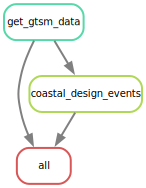

In [9]:
from IPython.display import SVG

# (test) run the workflow with snakemake and visualize the directed acyclic graph
# make sure to have snakemake installed in your environment
subprocess.run('snakemake --dag | dot -Tsvg > dag.svg', cwd=w.root, shell=True)

# show the dag
SVG(Path(w.root, "dag.svg").as_posix())